In [30]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Árbol de Decisión

1. Cargar las librerías

In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from collections import Counter

2. Cargamos los registros

In [32]:
path_entrenamiento = "train.csv"
path_testeo = "test.csv"

df_entrenamiento = pd.read_csv(path_entrenamiento, encoding="utf-8")
df_testeo = pd.read_csv(path_testeo, encoding="utf-8")

df_entrenamiento.head(), df_testeo.head()

(                                       mensaje  tipo
 0  Compra ahora y recibe un descuento especial   ham
 1           Haz clic aqui para ganar un premio  spam
 2                  Tu ordenador tiene un virus  spam
 3        Descubre como perder peso rapidamente  spam
 4                 Necesitas ayuda con tu tarea   ham,
                                         mensaje  tipo
 0           Tu devolucion esta siendo procesada   ham
 1       Gana dinero por compartir tus opiniones  spam
 2  Recordatorio de tu cita con el nutricionista   ham
 3     Quema grasa abdominal con este suplemento  spam
 4                    Agradecemos tu preferencia   ham)

3. Exploramos y limpiamos los datos

In [33]:
# Comprobamos la distribución de las clases
print(f"Distribución entrenamiento: {Counter(df_entrenamiento["tipo"])}")
print(f"Distribución testeo: {Counter(df_testeo["tipo"])}")

# Comprobamos nulos y duplicados
print(f"Nulos: {df_entrenamiento.isnull().sum()}")
print(f"Duplicados: {df_entrenamiento.duplicated().sum()}")

Distribución entrenamiento: Counter({'spam': 521, 'ham': 477})
Distribución testeo: Counter({'ham': 109, 'spam': 100})
Nulos: mensaje    0
tipo       0
dtype: int64
Duplicados: 147


4. Preparar los datos

In [34]:
X_train = df_entrenamiento["mensaje"].values
y_train = df_entrenamiento["tipo"].values

X_test = df_testeo["mensaje"].values
y_test = df_testeo["tipo"].values

5. Entrenamos el modelo: para entrenar el modelo, nuestro código va a convertir los mensajes de texto en una representación numérica
utilizando para ello la librería TF-IDF. Luego entrenaremos un árbol de decisión con los datos procesados.

In [35]:
# 1. Creamos un vectorizador
# Primer intento:
# vectorizador = TfidfVectorizer()
# Segundo intento:
# stopwords_list = ["a", "tu", "con", "hola"]
# vectorizador = TfidfVectorizer(stop_words=stopwords_list)
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stopwords_es = stopwords.words("spanish")
# vectorizador = TfidfVectorizer(stop_words=stopwords_es)
# Cuarto intento:
# ngram_range usa unigramas y bigramas (palabras individuales o pares)
# min_df ignora las palabras que se han utilizado ya una vez
vectorizador = TfidfVectorizer(stop_words=stopwords_es, ngram_range=(1,2), min_df=2)

# 2. Definir el modelo de árbol de decisión.
# Primer intento:
# clasificador = DecisionTreeClassifier(max_depth=3, random_state=42)
# Segundo intento:
clasificador = DecisionTreeClassifier(max_depth=5, class_weight='balanced')

# 3. Ajustamos el vectorizador TF-IDF con los datos de entrenamiento
X_train_tfidf = vectorizador.fit_transform(X_train)

# 4. Entrenamos el modelo con los datos transformados
clasificador.fit(X_train_tfidf, y_train)

X_train_tfidf, clasificador

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IABD12\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 4788 stored elements and shape (998, 1322)>,
 DecisionTreeClassifier(class_weight='balanced', max_depth=5))

6. Evaluamos el modelo

In [36]:
# Transformar los datos de prueba
X_test_tfidf = vectorizador.transform(X_test)

# Vamos a hacer predicciones sobre el conjunto de prueba utilizando el modelo
y_pred = clasificador.predict(X_test_tfidf)

# Obtenemos la accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Imprimimos un reporte de clasificación
print(f"Informe: {classification_report(y_test, y_pred)}")
# Precision: proporción de las predicciones positivas correctas
# Recall/Sensibilidad: proporción los casos reales correctamente predichos
# F1: media armónica entre la preción y la sensiblidad
# Support: número de muestras en cada categoría
# MacroAVG: media de las métricas
# WeightedAVG: como la macro, pero teniendo en cuenta el support (número de muestras)


Accuracy: 0.5502392344497608
Informe:               precision    recall  f1-score   support

         ham       1.00      0.14      0.24       109
        spam       0.52      1.00      0.68       100

    accuracy                           0.55       209
   macro avg       0.76      0.57      0.46       209
weighted avg       0.77      0.55      0.45       209



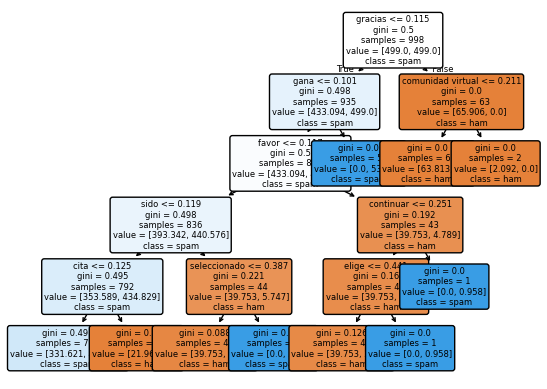

In [37]:
# Visualización del árbol
plt.figure()
plot_tree(
    clasificador,
    feature_names=vectorizador.get_feature_names_out(),
    class_names=["ham", "spam"],
    filled=True,
    rounded=True,
    fontsize=6
)

plt.show()

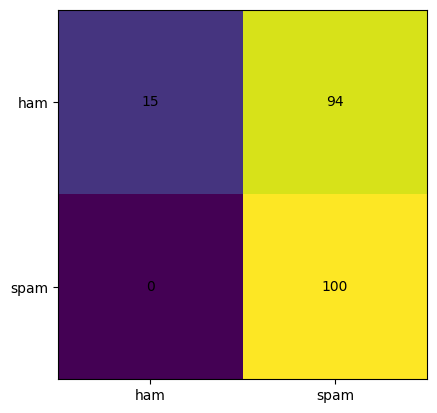

In [42]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=["ham", "spam"])
fig, ax = plt.subplots()
ax.imshow(cm)
ax.set_xticks([0,1])
ax.set_xticklabels(["ham", "spam"])
ax.set_yticks([0,1])
ax.set_yticklabels(["ham", "spam"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], ha="center", va="center")
plt.show()

7. Importancia de Características

In [43]:
falsos_positivos = df_testeo[(y_test == "ham") & (y_pred == "spam")]
print(falsos_positivos)

                                          mensaje tipo
0             Tu devolucion esta siendo procesada  ham
4                      Agradecemos tu preferencia  ham
6    Firma el acuerdo de confidencialidad adjunto  ham
8             Confirmamos que recibimos tu pedido  ham
10                Tu reclamo esta siendo atendido  ham
..                                            ...  ...
199                       Tu pin temporal es 3897  ham
202     Tus ideas nos inspiran a seguir mejorando  ham
204      Tu nomina esta disponible para descargar  ham
206                  Elige entre debito o credito  ham
207             Salva una vida donando sangre hoy  ham

[94 rows x 2 columns]


8. Comprobamos distribuciones y clasificados

In [ ]:
w5UgBY7_u6<C#1